<a href="https://colab.research.google.com/github/wissemkarous/CodeClause_Spam-Classifier/blob/main/spam_mail_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

**Spam Mail Classifier**

In [1]:
# Handling Data
import pandas as pd
import numpy as np

# Visialization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# For Text processing 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# DL
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential

#Accuracy Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



## Reading Data

In [3]:
df = pd.read_csv('/content/archive (4).zip')
# Removing Unnecessary column
df.drop('Unnamed: 0', axis=1, inplace = True)
# Changing column names
df.columns = ['label', 'text', 'class']

In [ ]:
df.head()

,label,text,class
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
df.shape

(5171, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   object
 1   text    5171 non-null   object
 2   class   5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [6]:
# No NaN in the data
df.isna().sum()

label    0
text     0
class    0
dtype: int64

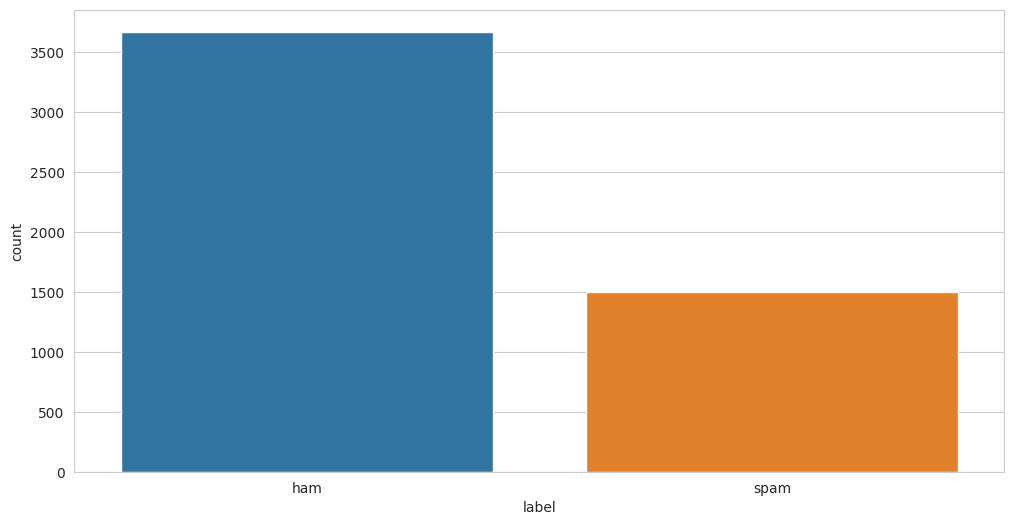

In [7]:
# Barplot describes the count of the class labels
plt.figure(figsize = (12, 6))
sns.countplot(data = df, x = 'label');

## Viewing samples of the data

In [8]:
# Let's see few examples of the data

for i in df.iterrows():
    print("Class Label: {}\nMail: \n{}\n\n".format(i[1][0], i[1][1]))
    if i[0] == 6: break
   

Class Label: ham
Mail: 
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


Class Label: ham
Mail: 
Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls


Class Label: ham
Mail: 
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 

## Remove stopwords from the data

In [40]:
%%time
import nltk

>>> nltk.download()

stop_words = set(stopwords.words('english')) 
df['text'] = df['text'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

SyntaxError: ignored

In [10]:
df.sample(10)

,label,text,class
4216,spam,Subject: 75 % off all vacations\r\n,1
1354,ham,Subject: hl & p december\r\njanet . attached i...,0
2685,spam,Subject: heisser fetish\r\nmann war das ein wo...,1
2930,ham,"Subject: enron / hpl actuals for january 24 , ...",0
3543,ham,Subject: duke energy meter 6722 may 2001\r\nme...,0
727,ham,Subject: january nominations at shell deer par...,0
1270,ham,Subject: meter 1031 baytown exxon\r\ndaren - t...,0
3273,ham,Subject: moving the list . . .\r\nbammelyoungf...,0
2461,spam,Subject: nathaniel energy ( otcbb : necx ) str...,1
3953,spam,Subject: italian crafted rolex from $ 75 to $ ...,1


In [11]:
X = df.loc[:, 'text']
y = df.loc[:, 'class']

print(f"Shape of X: {X.shape}\nshape of y: {y.shape}")

Shape of X: (5171,)
shape of y: (5171,)


## Split data into **train** and **test** in 80:20

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [13]:
print(f"Train Data Shape: {X_train.shape}\nTest Data Shape: {X_test.shape}")

Train Data Shape: (4136,)
Test Data Shape: (1035,)


## Preprocess text to build the ML mdel

In [14]:
cVect = CountVectorizer()
cVect.fit(X_train)

CountVectorizer()

  Let's see the vocabulary that has extracted by hte count vextorizer

In [15]:
print('NO.of Tokens: ',len(cVect.vocabulary_.keys()))

NO.of Tokens:  44402


In [16]:
# document term vector (dtv)
dtv = cVect.transform(X_train)

In [17]:
type(dtv)

scipy.sparse._csr.csr_matrix

In [18]:
dtv = dtv.toarray()

In [19]:
print(f"Number of Observations: {dtv.shape[0]}\nTokens/Features: {dtv.shape[1]}")

Number of Observations: 4136
Tokens/Features: 44402


In [20]:
# Let's see an sample that has been preprocessed
dtv[1]

array([0, 0, 0, ..., 0, 0, 0])

### Logistic Regression.

##### **Logistic Regression** could help use predict whether the student passed or failed. Logistic regression predictions are discrete (only specific values or categories are allowed). We can also view probability scores underlying the model’s classifications.

### Hyperparameter Tuning

In [21]:
lr = LogisticRegression(verbose=1)

grid={"C":[float(i) for i in range(1, 3)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
logreg_cv=GridSearchCV(lr, grid, cv=4)
logreg_cv.fit(dtv,y_train)

print("Tuned Hpyerparameters :",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Tuned Hpyerparameters : {'C': 2.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.976063829787234


In [22]:
%%time
lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 1.0)
lr.fit(dtv, y_train)

CPU times: user 1.23 s, sys: 568 ms, total: 1.8 s
Wall time: 1.45 s


LogisticRegression(solver='liblinear')

## Evaluate on the Test data

In [23]:
# Preprocess the test data
test_dtv = cVect.transform(X_test)
test_dtv = test_dtv.toarray()
print(f"Number of Observations: {test_dtv.shape[0]}\nTokens/Features: {test_dtv.shape[1]}")

Number of Observations: 1035
Tokens/Features: 44402


In [24]:
%%time
pred = lr.predict(test_dtv)

CPU times: user 105 ms, sys: 87.4 ms, total: 193 ms
Wall time: 168 ms


In [25]:
print('Accuracy: ', accuracy_score(y_test, pred) * 100)

Accuracy:  97.3913043478261


  Classification Report of the classifier

In [26]:
# 0 - Not Spam / Ham
# 1 - Spam 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       744
           1       0.94      0.97      0.95       291

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



  Confusion Matrix

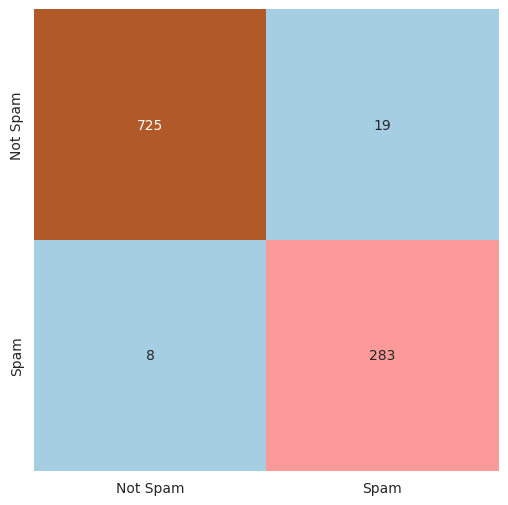

In [27]:
cmat = confusion_matrix(y_test, pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam']);

## Predict Class label for the unseen data i.e., Spam or Not Spam

In [28]:
# 'You won 1000$ prize money in lottery. Click here to avail'
def predict_class(lr):
    text = input('Enter Text(Subject of the mail): ')
    text = [' '.join([ word for word in word_tokenize(text)  if not word in stop_words])]
    t_dtv = cVect.transform(text).toarray()
    print('Predicted Class:', end = ' ')
    print('Spam' if lr.predict(t_dtv)[0] else 'Not Spam') 
    prob = lr.predict_proba(t_dtv)*100
    print(f"Not Spam: {prob[0][0]}%\nSpam: {prob[0][1]}%")
    plt.figure(figsize=(12, 6))
    sns.barplot(x =['Not Spam', 'Spam'] , y = [prob[0][0], prob[0][1]])
    plt.xlabel('Class')
    plt.ylabel('Probalility')
    plt.show()


In [ ]:
predict_class(lr)



---



### Do Upvote the Notebook, If you like.